In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit

- participant_id: unique identifier for the participant.
- group: group classification (patient or control).
- intensity: stimulus brightness intensity (scale from 1 to 10).
- response: binary response (1 = correct, 0 = incorrect).
- reaction_time: reaction time in milliseconds.


In [18]:
df = pd.read_csv('visual_attention_task.csv')

In [19]:
df

,participant_id,group,intensity,response,reaction_time
0,0,patient,1.129538,0.0,681.552703
1,0,patient,1.129538,0.0,NaN
2,0,patient,1.129538,0.0,616.068190
3,0,patient,1.129538,0.0,520.407812
4,0,patient,1.129538,0.0,563.600231
...,...,...,...,...,...
7995,39,control,9.860497,1.0,465.073278
7996,39,control,9.860497,1.0,521.574438
7997,39,control,9.860497,1.0,444.301077
7998,39,control,9.860497,1.0,560.190276


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  8000 non-null   int64  
 1   group           8000 non-null   object 
 2   intensity       8000 non-null   float64
 3   response        7995 non-null   float64
 4   reaction_time   7990 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 312.6+ KB


In [22]:
cleaned_df = df.dropna(subset=["response", "reaction_time"]).reset_index(drop=True)
cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7985 entries, 0 to 7984
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  7985 non-null   int64  
 1   group           7985 non-null   object 
 2   intensity       7985 non-null   float64
 3   response        7985 non-null   float64
 4   reaction_time   7985 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 312.0+ KB


,participant_id,group,intensity,response,reaction_time
0,0,patient,1.129538,0.0,681.552703
1,0,patient,1.129538,0.0,616.068190
2,0,patient,1.129538,0.0,520.407812
3,0,patient,1.129538,0.0,563.600231
4,0,patient,1.129538,0.0,591.249212
...,...,...,...,...,...
7980,39,control,9.860497,1.0,465.073278
7981,39,control,9.860497,1.0,521.574438
7982,39,control,9.860497,1.0,444.301077
7983,39,control,9.860497,1.0,560.190276


In [27]:
correct_responses = cleaned_df.groupby(['group', 'intensity'])['response'].mean() * 100

correct_responses = correct_responses.reset_index()

correct_responses.rename(columns={'response': 'percentage_correct'}, inplace=True)
correct_responses

,group,intensity,percentage_correct
0,control,0.421163,0.0
1,control,0.640974,0.0
2,control,0.663844,0.0
3,control,0.765236,0.0
4,control,0.850386,0.0
...,...,...,...
395,patient,10.169032,100.0
396,patient,10.198385,100.0
397,patient,10.211563,100.0
398,patient,10.238110,90.0


In [28]:
mean_reaction_times = cleaned_df.groupby('group')['reaction_time'].mean()
print(mean_reaction_times)


group
control    500.394681
patient    598.654316
Name: reaction_time, dtype: float64


In [29]:
reaction_times_control = cleaned_df[cleaned_df['group'] == 'control']['reaction_time']
reaction_times_patient = cleaned_df[cleaned_df['group'] == 'patient']['reaction_time']

t_stat, p_value = ttest_ind(reaction_times_control, reaction_times_patient)

print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

t-statistic: -92.597, p-value: 0.000e+00


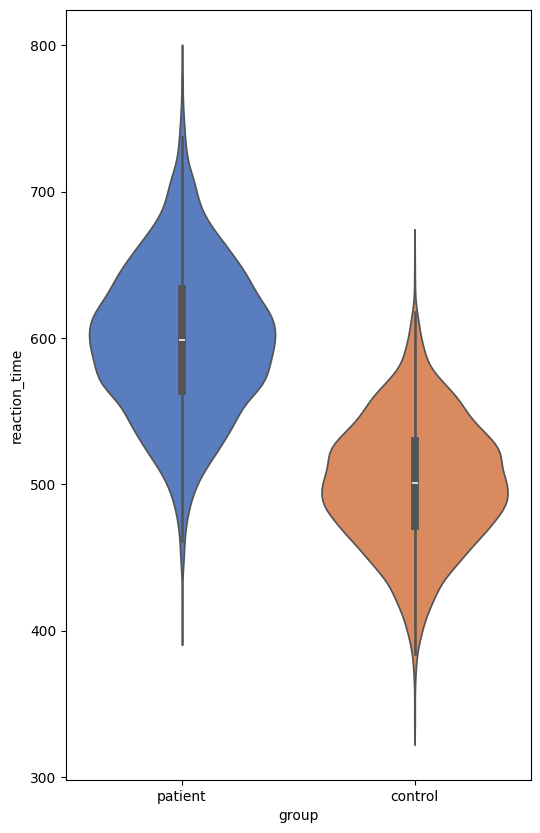

In [43]:
plt.figure(figsize=(6, 10))
sns.violinplot(data=cleaned_df, x='group', y='reaction_time', hue='group', inner="box", palette="muted", legend=False)

plt.show()


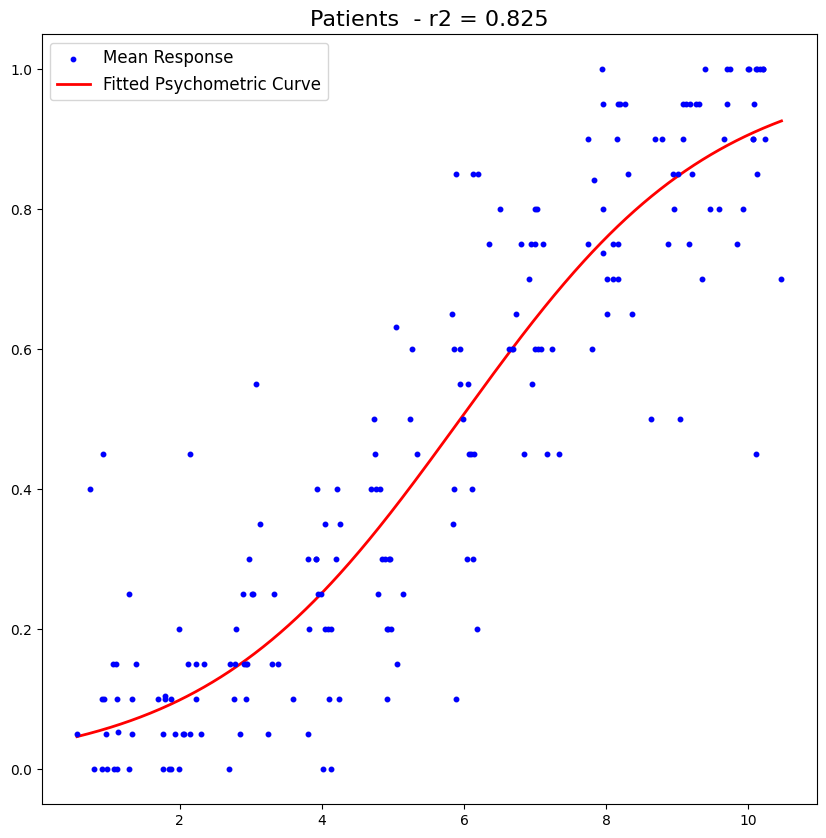

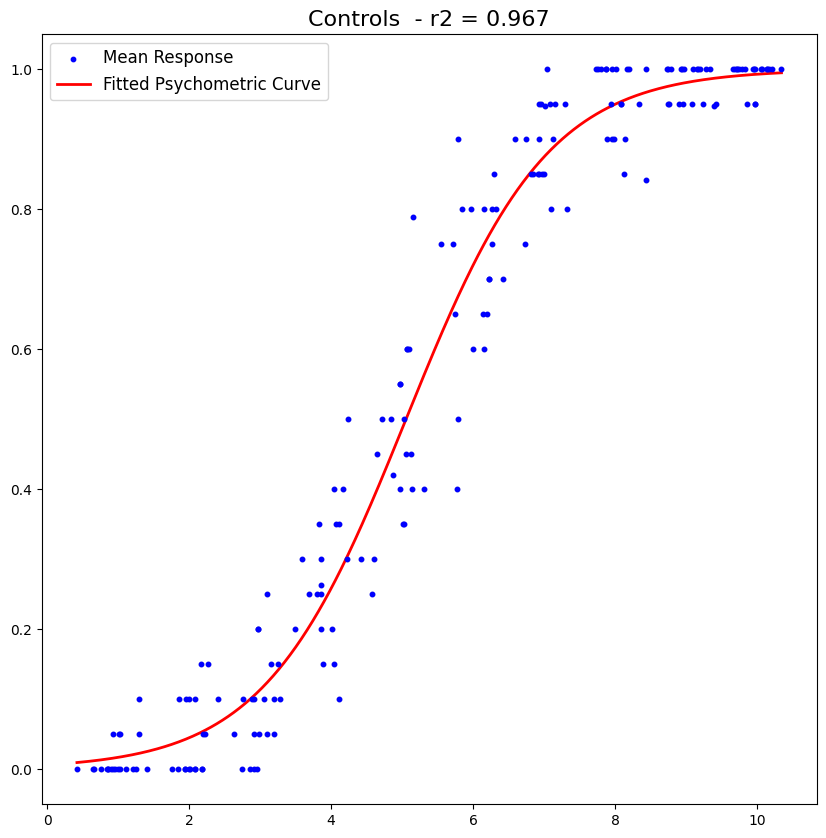

In [69]:
def plot_psychometric_curve(data, group_name, color):
    subject_means = data.groupby(['participant_id', 'intensity'])['response'].mean().reset_index()

    intensity_means = subject_means.groupby('intensity')['response'].mean().reset_index()

    def sigmoid(x, alpha, beta):
        return 1 / (1 + np.exp(-(x - alpha) / beta))

    popt, _ = curve_fit(sigmoid, intensity_means['intensity'], intensity_means['response'], p0=[5, 1])

    alpha, beta = popt

    intensity_values = intensity_means['intensity']
    y_observed = intensity_means['response']
    y_predicted = sigmoid(intensity_values, alpha, beta)

    ss_res = np.sum((y_observed - y_predicted) ** 2)
    ss_tot = np.sum((y_observed - np.mean(y_observed)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    plt.figure(figsize=(10, 10))

    for participant_id, participant_data in subject_means.groupby('participant_id'):
        plt.scatter(participant_data['intensity'], participant_data['response'], color='gray', alpha=0.4, s=10)

    plt.scatter(intensity_means['intensity'], intensity_means['response'], 
                color='blue', label='Mean Response', zorder=3, s=10) 

    x_values = np.linspace(data['intensity'].min(), data['intensity'].max(), 500)
    fit_curve = sigmoid(x_values, *popt)
    plt.plot(x_values, fit_curve, color=color, label='Fitted Psychometric Curve', linewidth=2)

    plt.title(f"{group_name.capitalize()}  - r2 = {r2:.3f}", fontsize=16)
    plt.legend(fontsize=12)

    plt.show()

    return r2


patients_data = cleaned_df[cleaned_df['group'] == 'patient']
controls_data = cleaned_df[cleaned_df['group'] == 'control']

r2_patients = plot_psychometric_curve(patients_data, group_name="patients", color="red")

r2_controls = plot_psychometric_curve(controls_data, group_name="controls", color="red")
